In [1]:
import sys
sys.path.append('..')

import torch
from tqdm import tqdm
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightning as L
seed = 42
L.seed_everything(seed, workers=True)

from src.models.unet_module import UnetLitModule
from src.models.gan_module import UnetGANLitModule
from src.models.ae_module import AutoencoderKL, EncoderLRES
from src.models.ldm_module import LatentDiffusion

from src.models.components.unet import DownscalingUnet
from src.models.components.ae import SimpleConvDecoder, SimpleConvEncoder
from src.models.components.ldm.denoiser import UNetModel, DDIMSampler
from src.models.components.ldm.conditioner import AFNOConditionerNetCascade
from src.data.downscaling_datamodule import DownscalingDataModule
from src.data.components.downscaling_dataset import DownscalingDataset

from utils.inference_utils import get_model_output
from utils.plotting_utils import get_target_grid, from_torchtensor_to_xarray

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/users/par55/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
[rank: 0] Global seed set to 42


Pysteps configuration file found at: /home/users/par55/.local/lib/python3.10/site-packages/pysteps/pystepsrc



In [2]:
# Set paths
trained_models_path = '../pretrained_models/'
data_path = '../data/'
output_path = '../outputs/'

static_vars = {'dtm_tif_file': data_path + 'static_var/dtm_2km_domain_trim_EPSG3035.tif',
               'lc_tif_file': data_path + 'static_var/land_cover_classes_2km_domain_trim_EPSG3035.tif',
               'lat_tif_file': data_path + 'static_var/lat_2km_domain_trim_EPSG3035.tif'}

borders_file = data_path + 'plotting_resources/borders_downscaling_domain_3035.geojson'

# Read in the data normalization info
with open(data_path + 'normalization_data.pkl', 'rb') as f:
    norm_values = pickle.load(f)

# Fix number of test timestep to perform
nr_timesteps = 5

In [3]:
# Choose the target variables (either '2mT' or 'UV')
# target_var = '2mT'
target_var = 'UV'

target_channels = 1 if target_var == '2mT' else 2
target_vars = {'high_res': ['2mT']} if target_var == '2mT' else {'high_res': ['U10', 'V10']}
target_vars['low_res'] = ['2mT', 'PMSL', 'U10', 'V10', 'dp2mT', 'SST', 'SNDPT', 'TP', 'SSRadIn', 'Q850', 'T850', 'U850', 'V850', 'W850']

tv_idxs = {}
for tv in target_vars['high_res']:
    tv_idxs[tv] = [i for i in range(len(target_vars['low_res'])) if target_vars['low_res'][i] == tv][0]

Loading checkpoint from: ../pretrained_models/UNET_UV.ckpt


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


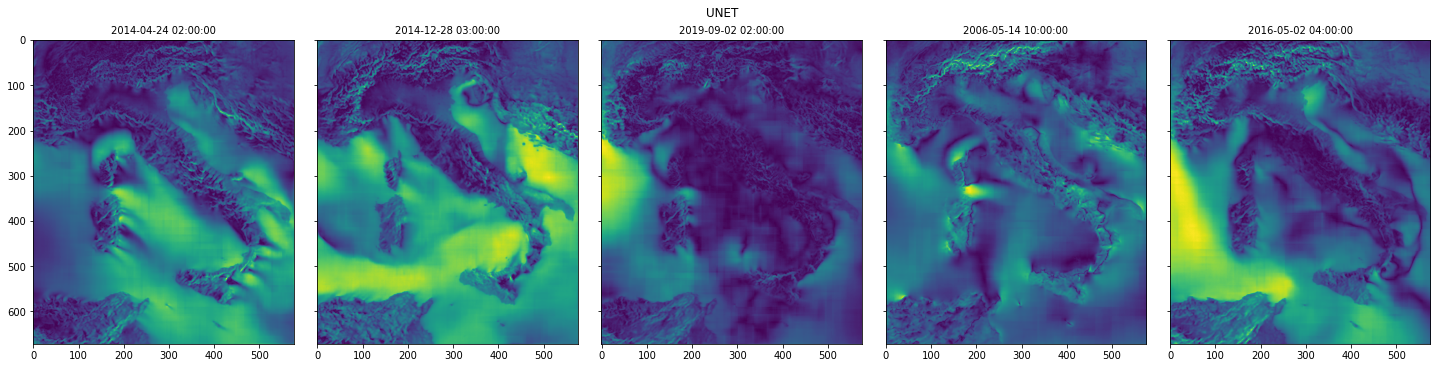

In [10]:
# Load the UNET model 
ckpt_ref_file = trained_models_path + 'UNET_' + target_var + '.ckpt'
print("Loading checkpoint from:", ckpt_ref_file)

import torch

# Load the checkpoint from disk
ckpt = torch.load(ckpt_ref_file, map_location='cpu')

# Remove keys that reference external files from the training environment
for key in ["callbacks", "loops", "optimizer_states", "lr_schedulers"]:
    if key in ckpt:
        ckpt.pop(key)

# Ensure the hyperparameters do not trigger an extra checkpoint load:
if "hyper_parameters" in ckpt:
    if "ckpt_path" in ckpt["hyper_parameters"]:
         ckpt["hyper_parameters"]["ckpt_path"] = None

# Save the modified checkpoint (optional, for reuse)
modified_ckpt_file = ckpt_ref_file.replace(".ckpt", "_modified.ckpt")
torch.save(ckpt, modified_ckpt_file)

# Create loss, input channels, and output channels
loss = torch.nn.Identity()
in_ch = 18 + 14  # 18 static variables + 14 predictors
out_ch = target_channels

# Load the UNet model from the modified checkpoint,
# explicitly overriding ckpt_path to avoid trying to load an extra file.
unet_model = UnetLitModule.load_from_checkpoint(
    modified_ckpt_file,
    net=DownscalingUnet(in_ch=in_ch, out_ch=out_ch),
    loss=loss,
    ckpt_path=None,   # override to prevent loading from external path
    strict=False
).eval().to('cuda:0')

nn_lowres = True

# Set up test dataloader
data_module_unet = DownscalingDataModule(
    data_dir=data_path, 
    target_vars=target_vars,
    batch_size=1,
    num_workers=1
)
data_module_unet.data_test = DownscalingDataset(
    data_path,
    target_vars=target_vars,
    nn_lowres=nn_lowres,
    static_vars=static_vars, 
    metadata_file_name='metadata_test_paper_sample.csv'
)
test_dataloader_unet = data_module_unet.test_dataloader()
test_iter_unet = iter(test_dataloader_unet)
unet_preds_norm = {}

# Run the UNET on the test dataset
for idx_preds in tqdm(range(0, nr_timesteps)):
    el = next(test_iter_unet)
    model_output, ts_ns = get_model_output('unet-like', unet_model, el)
    ts_ns = pd.to_datetime(int(ts_ns))
    unet_preds_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        unet_preds_norm[ts_ns][tv] = (
            model_output.cpu()[0, index, :, :] * norm_values['CMCC']['std'][tv] +
            norm_values['CMCC']['mean'][tv]
        )
    if target_var == 'UV':
        unet_preds_norm[ts_ns]['WS10'] = np.sqrt(
            unet_preds_norm[ts_ns]['U10']**2 + unet_preds_norm[ts_ns]['V10']**2
        )

# Plot data
plot_var = '2mT' if target_var == '2mT' else 'WS10'
fig, ax_unet = plt.subplots(
    ncols=nr_timesteps,
    figsize=(4 * nr_timesteps, 5),
    sharey=True,
    sharex=True,
    constrained_layout=True
)
fig.suptitle('UNET')
for idx_preds, ts_ns in enumerate(unet_preds_norm):
    ax_unet[idx_preds].imshow(unet_preds_norm[ts_ns][plot_var])
    ax_unet[idx_preds].set_title(ts_ns, fontsize=10)


/home/users/par55/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
/home/users/par55/.local/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:164: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss.discriminator.main.0.weight', 'loss.discriminator.main.0.bias', 'loss.discriminator.main.2.weight', 'loss.discriminator.main.3.weight', 'loss.discriminator.main.3.bias', 'loss.discriminator.main.3.running_mean', 'loss.discriminator.main.3.running_var', 'loss.discriminator.main.3.num_batches_tracked', 'loss.discriminator.main.5.weight', 'loss.discriminator.main.6.weight', 'loss.discriminator.main.6.bias', 'loss.discriminator.main.6.running_mean', 'loss.discriminator.main.6.running_var', 'loss.discriminator.main

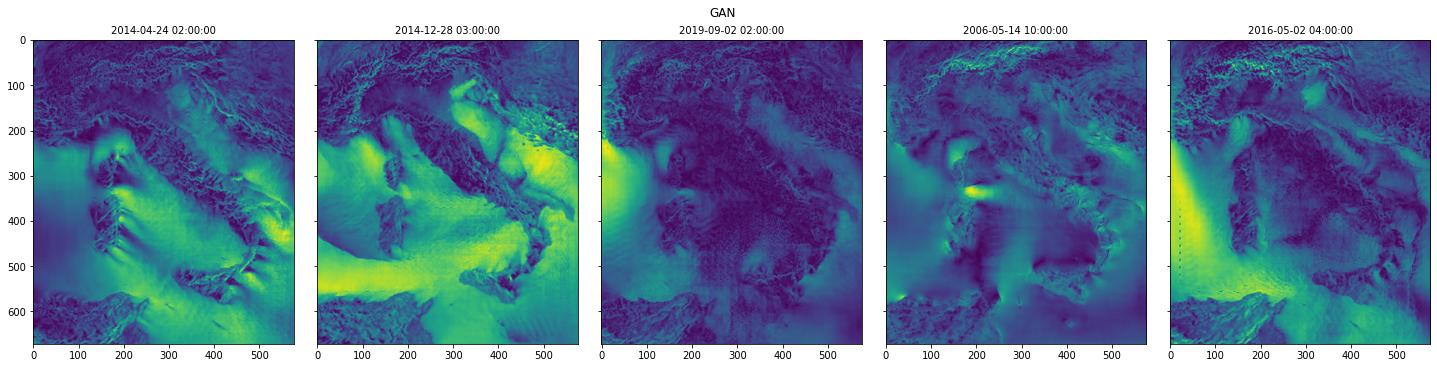

In [11]:
# Load the GAN model
ckpt_ref_file = trained_models_path + 'GAN_' + target_var + '.ckpt'
loss = torch.nn.Identity()
in_ch = 18 + 14  # 18 static variables + 14 predictors
out_ch = target_channels
gan_model = UnetGANLitModule.load_from_checkpoint(ckpt_ref_file,
                                              net=DownscalingUnet(in_ch=in_ch,out_ch=out_ch),
                                              loss=loss,
                                              strict=False).eval().to(device='cuda:0')
nn_lowres = True
# Set up test dataloader
data_module_gan = DownscalingDataModule(data_dir=data_path, 
                                    target_vars=target_vars,
                                    batch_size=1,
                                    num_workers=1)
data_module_gan.data_test = DownscalingDataset(data_path,
                                              target_vars=target_vars,
                                              nn_lowres=nn_lowres,
                                              static_vars=static_vars, 
                                              metadata_file_name='metadata_test_paper_sample.csv')
test_dataloader_gan = data_module_gan.test_dataloader()
test_iter_gan = iter(test_dataloader_gan)
gan_preds_norm = {}
# Run the GAN on the test dataset
for idx_preds in tqdm(range(0,nr_timesteps)):           
    el = next(test_iter_gan)
    model_output, ts_ns = get_model_output('unet-like', gan_model, el)
    ts_ns = pd.to_datetime(int(ts_ns))
    gan_preds_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        gan_preds_norm[ts_ns][tv] = model_output.cpu()[0,index,:,:]* norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        gan_preds_norm[ts_ns]['WS10'] = np.sqrt(gan_preds_norm[ts_ns]['U10'] **2 + gan_preds_norm[ts_ns]['V10']**2)

# Plot data
plot_var = '2mT' if target_var=='2mT' else 'WS10'
fig, ax_gan = plt.subplots(ncols=nr_timesteps,figsize=(4*nr_timesteps,5),sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('GAN')
for idx_preds,ts_ns in enumerate(gan_preds_norm):
    ax_gan[idx_preds].imshow(gan_preds_norm[ts_ns][plot_var])
    ax_gan[idx_preds].set_title(ts_ns, fontsize=10) 


/home/users/par55/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.0.5
  rank_zero_warn(
100%|██████████| 5/5 [01:02<00:00, 12.45s/it]


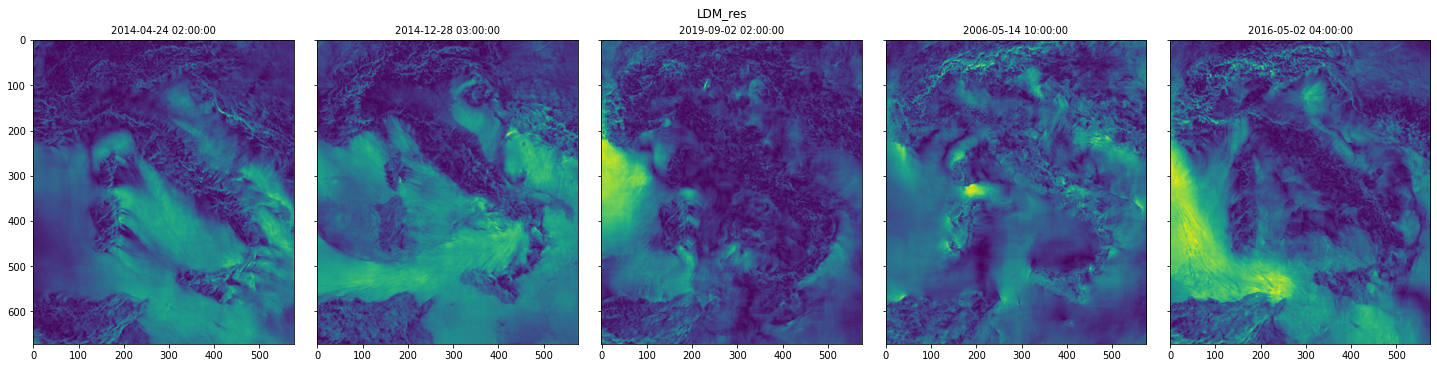

In [12]:
# Load the LDM_res model
ckpt_ref_file = trained_models_path + 'LDM_residual_' + target_var + '.ckpt'
ae_ckpt_ref_file = trained_models_path + 'VAE_residual_' + target_var + '.ckpt'
in_dim = target_channels
parameterization = 'v'
ae_flag = 'residual'
unet_regr = unet_model
ldm_res_model = LatentDiffusion.load_from_checkpoint(ckpt_ref_file,
                                            denoiser=UNetModel(in_channels=32*in_dim,
                                                            model_channels=256,
                                                            out_channels=32*in_dim,
                                                            num_res_blocks=2,
                                                            attention_resolutions=[1,2],
                                                            dims=2,
                                                            channel_mult=[1,2,4],
                                                            num_heads=8,
                                                            context_ch=[256,512,1024]),
                                            autoencoder=AutoencoderKL(encoder=SimpleConvEncoder(in_dim=in_dim, levels=3),
                                                                      decoder=SimpleConvDecoder(in_dim=in_dim, levels=3),
                                                                      ae_flag=ae_flag, 
                                                                      unet_regr=unet_regr),
                                            context_encoder=AFNOConditionerNetCascade(autoencoder=[AutoencoderKL(encoder=SimpleConvEncoder(in_dim=18,levels=3,ch_mult=3),
                                                                                                             decoder=None),
                                                                                               EncoderLRES()], 
                                                                                  train_autoenc=False,
                                                                                  cascade_depth=3,
                                                                                  embed_dim=[128,24],
                                                                                  analysis_depth=[4,4],
                                                                                  afno_fusion=True,
                                                                                  input_size_ratios=[1,1],
                                                                                  embed_dim_out=256),
                                            ae_load_state_file=ae_ckpt_ref_file, 
                                            parameterization=parameterization).eval().to(device='cuda:0')
nn_lowres = False
# Set up test dataloader
data_module_ldm = DownscalingDataModule(data_dir=data_path, 
                                    target_vars=target_vars,
                                    batch_size=1,
                                    num_workers=1)
data_module_ldm.data_test = DownscalingDataset(data_path,
                                              target_vars=target_vars,
                                              nn_lowres=nn_lowres,
                                              static_vars=static_vars, 
                                              metadata_file_name='metadata_test_paper_sample.csv')
test_dataloader_ldm = data_module_ldm.test_dataloader()
test_iter_ldm = iter(test_dataloader_ldm)
# Set up sampler
sampler = DDIMSampler(ldm_res_model)
denoising_steps = 100

ldm_preds_norm = {}
# Run the LDM on the test dataset
for idx_preds in tqdm(range(0,nr_timesteps)):          
    el = next(test_iter_ldm)
    model_output, ts_ns = get_model_output('ldm', ldm_res_model, el, sampler=sampler, num_diffusion_iters=denoising_steps)
    ts_ns = pd.to_datetime(int(ts_ns))
    ldm_preds_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        ldm_preds_norm[ts_ns][tv] = model_output.cpu()[0,index,:,:]* norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        ldm_preds_norm[ts_ns]['WS10'] = np.sqrt(ldm_preds_norm[ts_ns]['U10'] **2 + ldm_preds_norm[ts_ns]['V10']**2)

# Plot data
plot_var = '2mT' if target_var=='2mT' else 'WS10'
fig, ax_ldm = plt.subplots(ncols=nr_timesteps,figsize=(4*nr_timesteps,5),sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('LDM_res')
for idx_preds,ts_ns in enumerate(ldm_preds_norm):
    ax_ldm[idx_preds].imshow(ldm_preds_norm[ts_ns][plot_var])
    ax_ldm[idx_preds].set_title(ts_ns, fontsize=10) 



In [ ]:
# Store ERA5 and COSMO-CLM baseline datasets
test_iter_unet = iter(test_dataloader_unet)
era5_norm = {}
cosmo_norm = {}

for idx_preds in tqdm(range(0,nr_timesteps)):
    el = next(test_iter_unet)
    low_res = el[0]
    high_res = el[1]
    ts_ns = pd.to_datetime(int(el[2]))
    era5_norm[ts_ns] = {}
    cosmo_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        era5_norm[ts_ns][tv] = low_res[0, tv_idxs[tv],:,:]* norm_values['ERA5']['std'][tv] + norm_values['ERA5']['mean'][tv]
        cosmo_norm[ts_ns][tv] = high_res[0,index,:,:]* norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        era5_norm[ts_ns]['WS10'] = np.sqrt(era5_norm[ts_ns]['U10'] **2 + era5_norm[ts_ns]['V10']**2)
        cosmo_norm[ts_ns]['WS10'] = np.sqrt(cosmo_norm[ts_ns]['U10'] **2 + cosmo_norm[ts_ns]['V10']**2)

# Store Quadratic Interp. baseline datasets
test_iter_ldm = iter(test_dataloader_ldm)
quadratic_norm = {}

target_grid_low_res = get_target_grid('low')
target_grid_high_res = get_target_grid('high')

for idx_preds in tqdm(range(0,nr_timesteps)):
    el = next(test_iter_ldm)
    low_res = el[0]
    ts_ns = pd.to_datetime(int(el[3]))
    quadratic_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        era5_xr = from_torchtensor_to_xarray(low_res[0, tv_idxs[tv],:,:], target_grid_low_res, coords_name='y_x')
        quadratic_interp = era5_xr.interp_like(target_grid_high_res, method='quadratic', assume_sorted=False, kwargs={"fill_value": "extrapolate"})
        quadratic_interp = torch.from_numpy(quadratic_interp.values)
        quadratic_norm[ts_ns][tv] = quadratic_interp* norm_values['ERA5']['std'][tv] + norm_values['ERA5']['mean'][tv]
    if target_var == 'UV':
        quadratic_norm[ts_ns]['WS10'] = np.sqrt(quadratic_norm[ts_ns]['U10'] **2 + quadratic_norm[ts_ns]['V10']**2)   

# Plot data
mod_list = {'ERA5': era5_norm, 'COSMO-CLM': cosmo_norm, 'Quadratic Interp.': quadratic_norm}
for mod_i in mod_list:
    fig, ax = plt.subplots(ncols=nr_timesteps,figsize=(4*nr_timesteps,5),sharey=True, sharex=True, constrained_layout=True)
    fig.suptitle(mod_i)
    for idx_preds,ts_ns in enumerate(quadratic_norm):
        ax[idx_preds].imshow(mod_list[mod_i][ts_ns][plot_var])
        ax[idx_preds].set_title(ts_ns, fontsize=10) 


In [ ]:
# Prepare data for saving results and later plotting
results = {'ERA5': era5_norm, 
           'COSMO-CLM': cosmo_norm,
           'Quadratic Interp.': quadratic_norm,
           'UNET': unet_preds_norm,
           'GAN': gan_preds_norm,
           'LDM_res': ldm_preds_norm}

d = []
for mod_i in results:
    for ts in results[mod_i]:
        pred_ts = results[mod_i][ts]
        # print(pred_ts.dims)
        for tv in target_vars['high_res']:
            d.append({'input_var': 'all',
                      'target_var': target_var,
                      'model': mod_i,
                      'variable': tv,
                      'spat_distr': pred_ts[tv],
                      'min': np.percentile(pred_ts[tv],0.5),
                      'max': np.percentile(pred_ts[tv],99.5),
                      'time_step': ts})
        if target_var == 'UV':
            d.append({'input_var': 'all',
                      'target_var': target_var,
                      'model': mod_i,
                      'variable': 'WS10',
                      'spat_distr': pred_ts['WS10'],
                      'min': np.percentile(pred_ts['WS10'],0.5),
                      'max': np.percentile(pred_ts['WS10'],99.5),
                      'time_step': ts})
results_df = pd.DataFrame(d)

In [ ]:
# Save results for later plotting
results_df.to_pickle(output_path + './results_trained_models_' + target_var + '.pkl')  

In [ ]:
# # Load the VAE model
# ckpt_ref_file = trained_models_path + 'VAE_' + target_var + '.ckpt'
# in_dim = target_channels
# ae_flag = 'residual'
# unet_regr = unet_model
# vae_model = AutoencoderKL.load_from_checkpoint(ckpt_ref_file,
#                                         encoder=SimpleConvEncoder(in_dim=in_dim, levels=3),
#                                         decoder=SimpleConvDecoder(in_dim=in_dim, levels=3),
#                                         ae_flag=ae_flag,
#                                         unet_regr = unet_regr).eval().to(device='cuda:0')      